[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic

#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 2000
_streaming = True
_system_message = None

# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
#set environmet variables for langsmith
# This is a basic config to enable tracing of conversations and  utilization of memory
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [6]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")
# llm.invoke(messages)

# Define LLM with bound tools
llm = ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    max_tokens=_max_tokens,
    streaming=_streaming,
    verbose=True,
)

llm.invoke(messages)

AIMessage(content='Here are some other fascinating ocean mammals you could learn more about:\n\n- Dolphins - There are many different species of dolphins, from the well-known bottlenose dolphins to the less common species like the spinner dolphin and the Hector\'s dolphin. Dolphins are highly intelligent and social animals.\n\n- Seals and Sea Lions - These semiaquatic marine mammals come in a variety of species like the harbor seal, elephant seal, and California sea lion. They are known for their streamlined bodies, flippers, and ability to swim and dive.\n\n- Manatees - Also called "sea cows," manatees are large, gentle herbivores that live in warm coastal waters. They are closely related to the dugong, another marine mammal.\n\n- Sea Otters - These playful, furry creatures are known for floating on their backs and using tools. They have the densest fur of any mammal and play an important role in their ocean ecosystems.\n\n- Polar Bears - While not strictly an ocean mammal, polar bear

We can run our chat model in a simple graph with `MessagesState`.

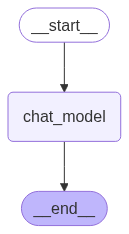

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
# invoke basic LLM using default MessagesState
# This is a basic config to enable tracing of conversations and  utilization of memory
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Here are some other fascinating ocean mammals you could learn more about:

- Dolphins - There are many different species of dolphins, from the well-known bottlenose dolphins to the less common species like the spinner dolphin and the Hector's dolphin. Dolphins are highly intelligent and social animals.

- Seals and Sea Lions - These semiaquatic marine mammals come in a variety of species like the harbor seal, elephant seal, and California sea lion. They are known for their streamlined bodies, flippers, and ability to swim and dive.

- Manatees - Also called "sea cows," manatees are large, gentle herbivores that l

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

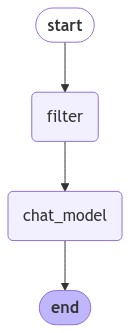

In [ ]:
from langchain_core.messages import RemoveMessage

# Nodes

# filter messages to only keep the last 2 to save on tokens
# the add_messages reducer that is part of the default MessagesState recognizes 
# the RemoveMessage and will remove messages from state based on the ids specified in the RemoveMessage
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are a variety of other fascinating ocean mammals you might be interested in learning about. Here are a few:

1. **Dolphins**: These highly intelligent and social animals are part of the cetacean family, which also includes whales and porpoises. There are many species of dolphins, including the common bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and teeth. The harbor porpoise is one of the more well-known sp

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

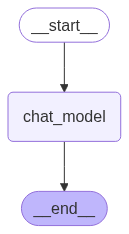

In [9]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [10]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [11]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Here are some other fascinating ocean mammals you could learn more about:

- Dolphins - There are many different species of dolphins, from the well-known bottlenose dolphins to the less common species like the spinner dolphin and the Hector's dolphin. Dolphins are highly intelligent and social animals.

- Seals and Sea Lions - These semiaquatic marine mammals come in a variety of species like the harbor seal, elephant seal, and California sea lion. They are known for their streamlined bodies, flippers, and ability to swim and dive.

- Manatees - Also called "sea cows," manatees are large, gentle herbivores that l

In [12]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Here are some other fascinating ocean mammals you could learn more about:

- Dolphins - There are many different species of dolphins, from the well-known bottlenose dolphins to the less common species like the spinner dolphin and the Hector's dolphin. Dolphins are highly intelligent and social animals.

- Seals and Sea Lions - These semiaquatic marine mammals come in a variety of species like the harbor seal, elephant seal, and California sea lion. They are known for their streamlined bodies, flippers, and ability to swim and dive.

- Manatees - Also called "sea cows," manatees are large, gentle herbivores that l

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

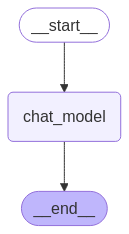

In [18]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [20]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [ ]:
# Invoke, using message trimming in the chat_model_node 
# Note: in langsmith tracing, you will see only the final message
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r